<center>
<h4>Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación</h4>
<h3>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones</h3>
</center>

<h1> Regresión Linear - Ejemplo </h1>
<h3> Análisis y Visualización de Datos - 2019 </h3>

En este ejemplo veremos cómo implementar una regresión logística para predecir una variable numérica. Volveremos a utilizar el dataset [Human Freedom Index 2018](https://www.cato.org/human-freedom-index-new) de el instituto Cato.

Usaremos una [versión ya limpia del dataset](https://www.kaggle.com/gsutters/the-human-freedom-index/home) que pueden descargar desde Kaggle.

En esta notebook vamos a tratar de estimar una función lineal que modele el cambio a través del tiempo de la libertad personal y la económica.

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
import pandas
import seaborn

In [5]:
seaborn.set_context(context='talk', font_scale=1.2)

In [6]:
BLUE = '#35A7FF'
RED = '#FF5964'
GREEN = '#6BF178'
YELLOW = '#FFE74C'

In [7]:
dataset = pandas.read_csv('../datasets/hfi_cc_2018.csv')
dataset.shape

(1458, 123)

En el práctico habíamos trabajado sobre las variables `ef_score` y `pf_score`, que hacen referencia a los índices de libertad personal y libertad económica de cada páis. Además, sabemos que el dataset incluye una medición del índice anual por país desde 2008 hasta 2016, aunque hay datos faltantes de algunos indicadores.

La motivación de este análisis comienza con este gráfico, que muestra una tendencia decreciente de la libertad personal y una tendencia ascendiente de la libertad económica. La libertad humana o `pf_score` es el promedio de ambos indicadores

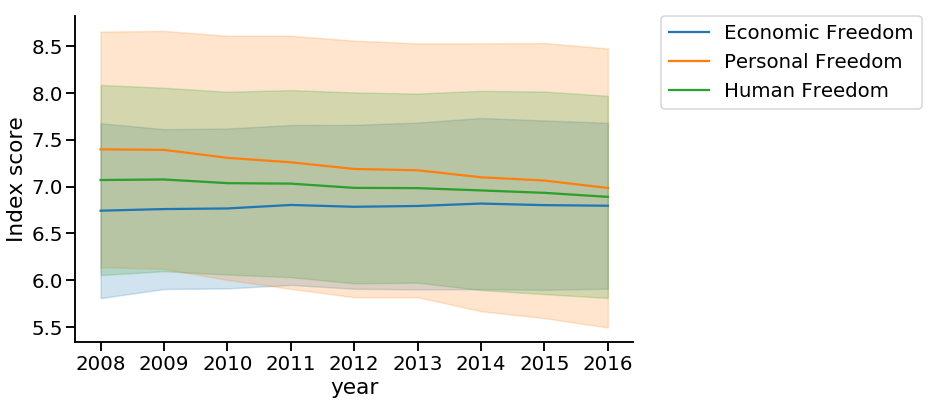

In [14]:
plt.figure(figsize=(10,6))
seaborn.lineplot(data=dataset,
                 x='year', y='ef_score',
                 label='Economic Freedom', ci='sd')
seaborn.lineplot(data=dataset,
                 x='year', y='pf_score',
                 label='Personal Freedom', ci='sd')

seaborn.lineplot(data=dataset,
                 x='year', y='hf_score',
                 label='Human Freedom', ci='sd')
plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Index score')
seaborn.despine()

Este fenómeno podría estar dado por varios factores:
  * Hay pocos países en los que la libertad personal está decreciendo, pero su libertad económica se mantiene constante.
  * Los países para los cuales sube la libertad económica decrecen en libertad personal.
  * **¿Otras?**

Veamos qué sucede en Argentina. Si graficamos ambas variables, vemos que "van bajando". Formalmente, esto significa que hay la recta que las modela tiene una pendiente negativa.

**¿Y esto, es grave?**

/home/milagro/anaconda3/envs/drl/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(2008, 2016)

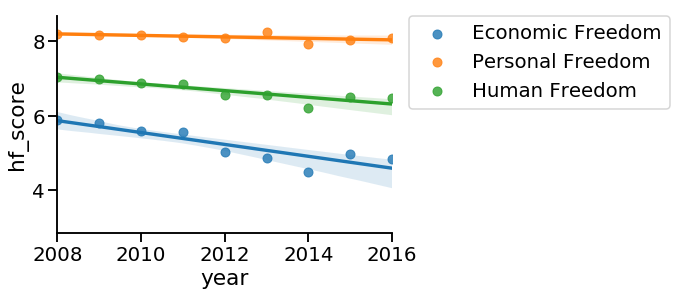

In [15]:
seaborn.regplot(data=dataset[(dataset.ISO_code == 'ARG')],
                    x='year', y='ef_score', label='Economic Freedom')
seaborn.regplot(data=dataset[(dataset.ISO_code == 'ARG')],
                    x='year', y='pf_score', label='Personal Freedom')
seaborn.regplot(data=dataset[(dataset.ISO_code == 'ARG')],
                    x='year', y='hf_score', label='Human Freedom')
plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
seaborn.despine()
plt.xlim(2008, 2016)

Podemos graficar varios países, pero es difícil comparar visualmente entre tantas variables, qué países "decrecen" más rápido que otros.

Scores de libertad para Medio Oriente


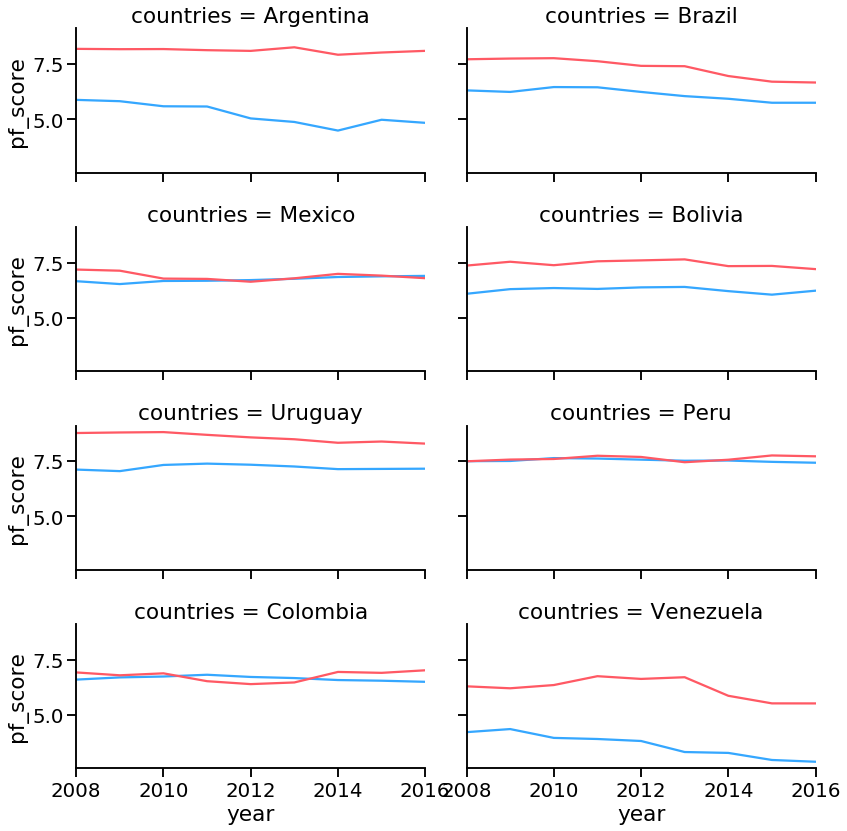

In [59]:
countries = ['Argentina', 'Brazil', 'Mexico', 'Bolivia',
             'Uruguay', 'Peru', 'Colombia', 'Venezuela']
g = seaborn.FacetGrid(dataset, col="countries",
                      margin_titles=True, aspect=2, col_wrap=2,
                      col_order=countries)
g.map(seaborn.lineplot, "year", "ef_score", color=BLUE)
g.map(seaborn.lineplot, "year", "pf_score", color=RED)
g.set(xlim=(2008, 2016))

print('Scores de libertad para Medio Oriente');

Para poder comparar la situación de Argentina con otros países, podemos comparar la pendiente de la recta de la regresión lineal. A partir del gráfico anterior pudimos ver que la mayoría de los países tiene tendencias similares y que se pueden estimar con una recta sin perder generalidad. Esto es posible también, en cierta medida, porque tenemos pocos puntos para estimar.

## Regresión lineal

Queremos ver cuál es el coeficiente que relaciona ambas variables.


Primero: **¿Cuál es la variable dependiente? ¿Cuál la independiente?**

Una vez que hemos determinado eso, lo que queremos encontrar es la función de la siguiente forma:

$$ef = a * year + b$$

Reescribiremos esto como una función $e$ (por economic), cuyo parámetro es el valor $y$ (por year):

$$e(y) = a * y + b$$

Vamos a describir los ejemplos como pares $(x_y, x_e)$, donde $x_y$ denota el `year` y $x_e$ denota `ef_score`. 

Para encontrar la recta $e$ que mejor describe los datos, queremos minimizar el error cuadrático medio, definido como:

$$mse = \frac{1}{|X|} \sum_{x \in X} (e(x_y) - x_e)^2 $$

Recordemos que para minimizar una función, una buena opción es comenzar por buscar los puntos estacionarios, donde la derivada se anula. Por suerte, la función $mse$ es convexa, y por lo tanto tiene todos sus puntos estacionarios son minimizadores. El minimizador es el valor de los parámetros $a$ y $b$ que minimizan la función. Ahora, en hemos cambiado nuestras "variables", lo que buscamos es encontrar la función adecuada, por lo tanto lo que cambia son los valores de los parámetros que definen la función. 

Primero, notemos que:

$$\frac{\partial}{\partial a}e(y) = x_p$$

$$\frac{\partial}{\partial b}e(y) = 1$$

Con eso, calculamos las derivadas parciales para cada parámetro de la función $mse$.

$$\frac{\partial}{\partial a}mse = \frac{2}{|X|} \sum_{x \in X} (e(x_p) - x_e) \frac{\partial}{\partial a} (e(x_p) - x_e) = \frac{2}{|X|} \sum_{x \in X} (e(x_p) - x_e) e_p $$

$$\frac{\partial}{\partial b}mse = \frac{2}{|X|} \sum_{x \in X} \frac{\partial}{\partial b} e(x_p) - x_e = \frac{2}{|X|} \sum_{x \in X} e(x_p) - x_e $$


A pesar del formulerío, es bastante simple. Sólo reemplazamos $mse$ por su definición, y luego aplicamos un par de reglas como "la derivada de la suma es la suma de las derivadas", la regla de la cadena, o la definición de la derivada de la función cuadrática.

Una vez que tenemos esos valores, tenemos que igualarlos a cero para encontrar los puntos estacionarios.

\begin{align}
 \frac{\partial}{\partial a}mse &= \frac{2}{|X|} \sum_{x \in X} (e(x_y) - x_e) x_y = 0 \\
                                &\Rightarrow a = \frac{\bar{x_y} \bar{x_e} - \overline{x_yx_e}}{(\bar{x_y})^2 - \overline{x_y^2}} 
\end{align}

\begin{align}
 \frac{\partial}{\partial b}mse &= \frac{2}{|X|} \sum_{x \in X} e(x_y) - x_e = 0 \\
                                &\Rightarrow b = \bar{x_e} - a \bar{x_y}
\end{align}

Donde $\bar{x}$ es la media del valor para todos los ejemplos. Vamos a confiar en estas fórmulas, pero una demostración de las mismas está en:

https://medium.freecodecamp.org/machine-learning-mean-squared-error-regression-line-c7dde9a26b93

In [17]:
def estimate_params(X_y, X_e):
    """Caculates the value of a using all the examples."""
    num = numpy.mean(X_y)*numpy.mean(X_e) - numpy.mean(numpy.multiply(X_y, X_e))
    denom = numpy.mean(X_y)**2 - numpy.mean(numpy.multiply(X_y, X_y))
    a = num / denom
    b = numpy.mean(X_e) - a * numpy.mean(X_y)
    return a, b

In [60]:
# Asumimos que todos los registros que tienen pf_score tienen el año.
a, b = estimate_params(
    dataset[(dataset.ISO_code == 'ARG') &
            (dataset.pf_score.notnull())].year.dropna(),
    dataset[dataset.ISO_code == 'ARG'].pf_score)
a, b

(-0.019938222416395018, 48.23648292700899)

In [33]:
def base_linear_regression(x_y, a):
    return a * x_y

In [34]:
def regplot2(data, x, y, reg_func, **reg_func_args):
    """Plots the x, y columns from data and builds a
    line with the regression reg_func."""
    seaborn.scatterplot(data=data, x=x, y=y, color=BLUE)
    minimum = data[x].min()
    maximum = data[x].max()
    plt.plot([minimum, maximum],
             [reg_func(minimum, **reg_func_args),
              reg_func(maximum, **reg_func_args)],
             color=GREEN)
    seaborn.despine()
    plt.show()

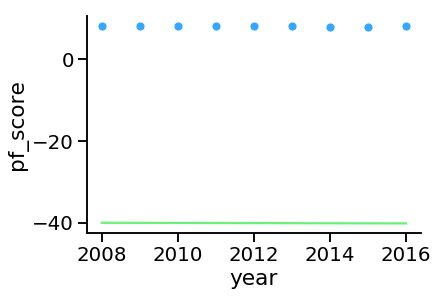

In [35]:
regplot2(dataset[dataset.ISO_code == 'ARG'],
         x='year', y='pf_score', reg_func=base_linear_regression,
         a=a)

Vemos que la recta va en el sentido correcto, pero está demasiado abajo. Esto ocurre porque no hemos usado el término de bias.

Redefinamos entonces la regresión logística

In [36]:
def linear_regression(x_y, a, b):
    return a * x_y + b

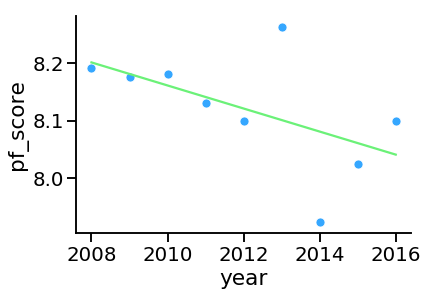

In [37]:
regplot2(dataset[dataset.ISO_code == 'ARG'],
         x='year', y='pf_score', reg_func=linear_regression,
         a=a, b=b)

## Continuamos el análisis

Perfecto! Ahora podemos calcular las pendientes y los biases para todos los años, para regresiones que estimen el `pf_score`.

In [39]:
def build_regressions(data, x_var='year', y_var='pf_score'):
    records = []
    for code in data.ISO_code.unique():
        record = [code, data[data.ISO_code == code].region.values[0],
                  data[data.ISO_code == code].countries.values[0]]
        y_data = data[data.ISO_code == code][y_var].dropna()
        # Comprobamos que hay datos en el intervalo
        if len(y_data) <= 1:
            continue
        x_data = data[(data.ISO_code == code) &
                      (data[y_var].notnull())][x_var].dropna()
        # Estimamos los parámetros
        a, b = estimate_params(x_data, y_data)
        # Calculamos el error cuadrático medio de la regresión lineal estimada
        predictions = numpy.apply_along_axis(
            lambda x: linear_regression(x, a, b), 0, x_data)
        mse = numpy.mean(numpy.power(predictions - y_data, 2))
        record.extend([a, b, mse])
        # Agregamos el registro
        records.append(record)
    return pandas.DataFrame.from_records(
        records, columns=['ISO_code', 'region', 'country',
                          'slope', 'bias', 'mse']
    )

In [40]:
pf_regressions = build_regressions(dataset).set_index('ISO_code')
pf_regressions[:10]

,region,country,slope,bias,mse
ISO_code,,,,,
ALB,Eastern Europe,Albania,-0.030238,68.536465,0.005275
DZA,Middle East & North Africa,Algeria,0.020887,-36.776002,0.005174
AGO,Sub-Saharan Africa,Angola,0.152157,-300.282847,0.128365
ARG,Latin America & the Caribbean,Argentina,-0.019938,48.236483,0.006254
ARM,Caucasus & Central Asia,Armenia,-0.075801,159.703656,0.012481
AUS,Oceania,Australia,-0.009244,27.829172,0.002955
AUT,Western Europe,Austria,0.046339,-84.027982,0.005218
AZE,Caucasus & Central Asia,Azerbaijan,-0.127696,262.997442,0.020314
BHS,Latin America & the Caribbean,Bahamas,-0.095505,199.892810,0.011764


/home/milagro/anaconda3/envs/drl/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


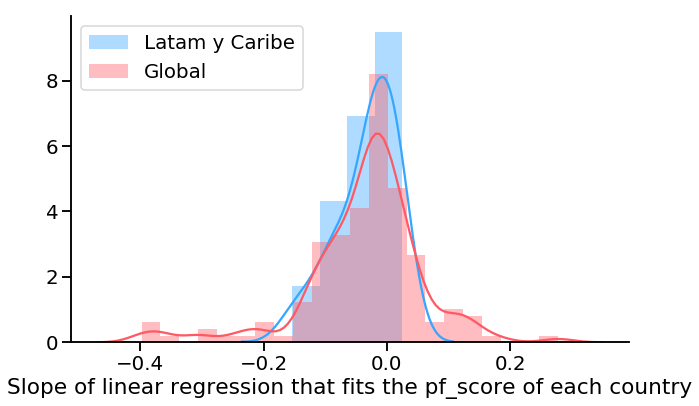

In [50]:
plt.figure(figsize=(10,6))
seaborn.distplot(
    pf_regressions[pf_regressions.region == 'Latin America & the Caribbean'].slope,
    color=BLUE, label='Latam y Caribe')
seaborn.distplot(pf_regressions.slope, color=RED, label='Global')
plt.xlabel('Slope of linear regression that fits the pf_score of each country')
plt.legend()
seaborn.despine()

In [43]:
def plot_regressions(regressions):
    plt.figure(figsize=(10,6))
    colors = seaborn.color_palette("cubehelix", len(regressions))
    for color, (year, row) in zip(colors, regressions.iterrows()):
        minimum, maximum = 2008, 2016
        plt.plot([minimum, maximum],
                 [linear_regression(minimum, row['slope'], row['bias']),
                  linear_regression(maximum, row['slope'], row['bias'])],
                 color=color, label=str(year), linestyle='--')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    seaborn.despine()

(4, 10)

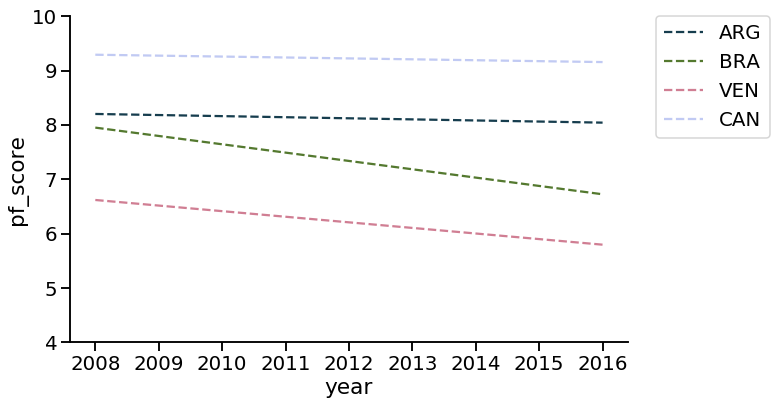

In [46]:
plot_regressions(pf_regressions.loc[['ARG', 'BRA', 'VEN', 'CAN']])
plt.xlabel('year')
plt.ylabel('pf_score')
plt.ylim(4, 10)

### Libertad Económica

In [47]:
ef_regressions = build_regressions(dataset, y_var='ef_score').set_index('ISO_code')
ef_regressions[:10]

,region,country,slope,bias,mse
ISO_code,,,,,
ALB,Eastern Europe,Albania,0.037167,-67.430444,0.006890
DZA,Middle East & North Africa,Algeria,-0.031167,67.739556,0.003564
AGO,Sub-Saharan Africa,Angola,0.061500,-118.595778,0.050513
ARG,Latin America & the Caribbean,Argentina,-0.159667,326.482667,0.045977
ARM,Caucasus & Central Asia,Armenia,0.005000,-2.425556,0.005080
AUS,Oceania,Australia,-0.006667,21.408889,0.001528
AUT,Western Europe,Austria,-0.007333,22.396889,0.000770
AZE,Caucasus & Central Asia,Azerbaijan,0.053833,-102.077111,0.007016
BHS,Latin America & the Caribbean,Bahamas,-0.024833,57.344667,0.003578


Text(0, 0.5, 'ef_score')

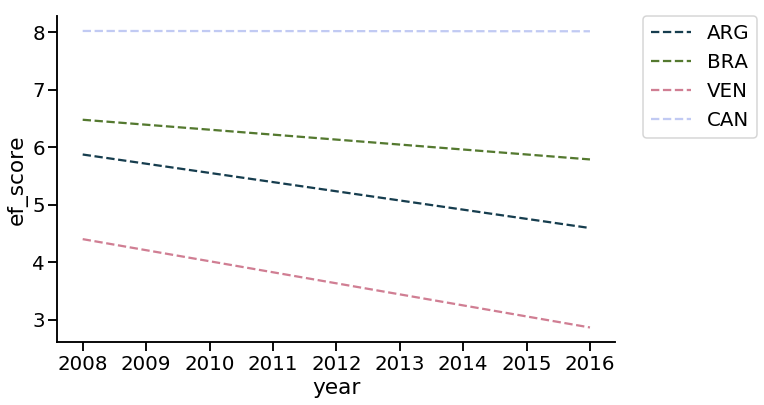

In [48]:
plot_regressions(ef_regressions.loc[['ARG', 'BRA', 'VEN', 'CAN']])
plt.xlabel('year')
plt.ylabel('ef_score')

/home/milagro/anaconda3/envs/drl/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


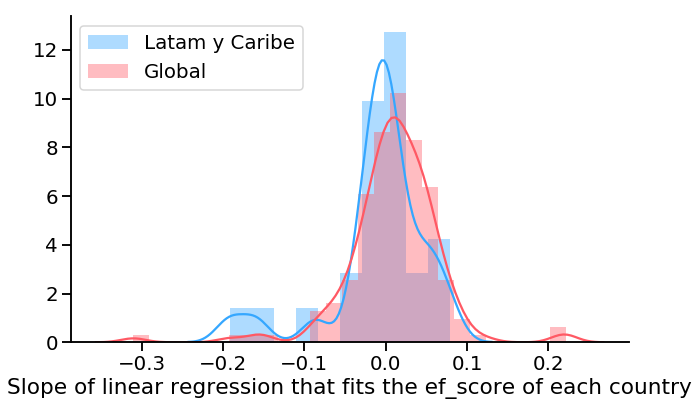

In [51]:
plt.figure(figsize=(10,6))
seaborn.distplot(
    ef_regressions[ef_regressions.region == 'Latin America & the Caribbean'].slope,
    color=BLUE, label='Latam y Caribe')
seaborn.distplot(ef_regressions.slope, color=RED, label='Global')
plt.xlabel('Slope of linear regression that fits the ef_score of each country')
plt.legend()
seaborn.despine()

## Análisis conjunto

**¿Cuáles es el 10% de países en los que la libertad humana disminuye más rápidamente?**

In [52]:
quantil = pf_regressions.slope.quantile(0.1)
pf_regressions[pf_regressions.slope < quantil].country

ISO_code
AZE           Azerbaijan
BRA               Brazil
BRN    Brunei Darussalam
BDI              Burundi
EGY                Egypt
GIN               Guinea
LBY                Libya
NIC            Nicaragua
NER                Niger
PHL          Philippines
SYR                Syria
TJK           Tajikistan
THA             Thailand
TLS          Timor-Leste
UKR              Ukraine
YEM          Yemen, Rep.
Name: country, dtype: object

**¿Cuáles es el 10% de países en los que la libertad económica disminuye más rápidamente?**

In [53]:
quantil = ef_regressions.slope.quantile(0.1)
ef_regressions[ef_regressions.slope < quantil].country

ISO_code
ARG          Argentina
BRA             Brazil
EGY              Egypt
FJI               Fiji
GHA              Ghana
GRC             Greece
IRN               Iran
KWT             Kuwait
LBR            Liberia
MWI             Malawi
NAM            Namibia
PNG    Pap. New Guinea
SYR              Syria
TUN            Tunisia
VEN          Venezuela
ZMB             Zambia
Name: country, dtype: object

**¿Cuáles son los paises en los que la libertad económica aumenta pero la libertad personal disminuye (rápidamente)?**

In [55]:
all_countries = dataset.ISO_code.unique()
codes = []
for code in all_countries:
    if (code in ef_regressions.index and code in pf_regressions.index and
        ef_regressions.loc[code].slope > 0.02 and
        pf_regressions.loc[code].slope < -0.02):
        codes.append(code)
ef_regressions.loc[codes].country

ISO_code
ALB           Albania
AZE        Azerbaijan
BTN            Bhutan
BDI           Burundi
KHM          Cambodia
CPV        Cape Verde
CHN             China
COD    Congo, Dem. R.
GMB       Gambia, The
GEO           Georgia
GTM         Guatemala
GIN            Guinea
IDN         Indonesia
ISR            Israel
KAZ        Kazakhstan
MKD         Macedonia
MYS          Malaysia
MEX            Mexico
MMR           Myanmar
NPL             Nepal
NIC         Nicaragua
NER             Niger
NGA           Nigeria
PRY          Paraguay
PHL       Philippines
POL            Poland
RUS            Russia
RWA            Rwanda
ESP             Spain
TJK        Tajikistan
TZA          Tanzania
TLS       Timor-Leste
YEM       Yemen, Rep.
Name: country, dtype: object

# Errores

Calculamos el mse pero nunca lo usamos. Veamos cómo son los países para los que la regresión linear no produce una buena aproximación

In [56]:
pf_regressions.mse.sort_values()[-10:]

ISO_code
GUY    0.110310
SLE    0.119609
UKR    0.124567
CAF    0.126684
AGO    0.128365
IND    0.128720
VEN    0.130987
BRN    0.153219
MMR    0.168191
BDI    0.221579
Name: mse, dtype: float64

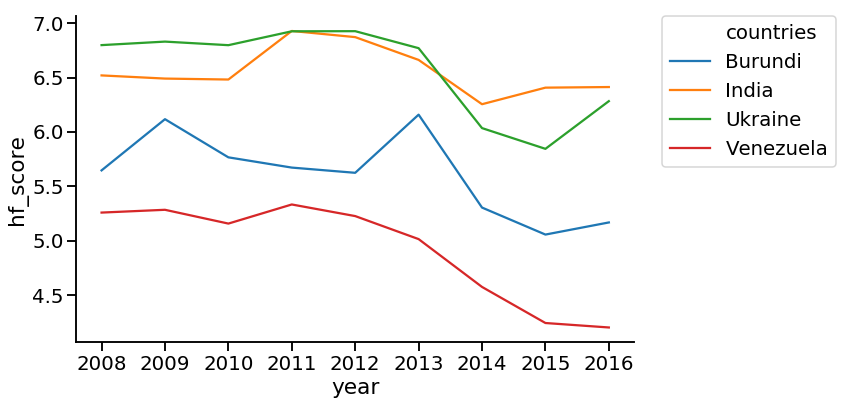

In [58]:
plt.figure(figsize=(10,6))
countries = ['BDI', 'VEN', 'IND', 'UKR']
seaborn.lineplot(data=dataset[dataset.ISO_code.isin(countries)], x='year', y='hf_score',
                 hue='countries')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
seaborn.despine()

Claramente se ve que estas funciones no podían ser estimadas satisfactoriamente con una recta, pero aún así, la tendencia general (descendiente o ascendiente) habría sido aproximada